In [40]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM, Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from keras.layers import GRU
from sklearn.feature_selection import SelectKBest, f_classif
from keras.regularizers import l2
from sklearn.metrics import recall_score
import seaborn as sns


# Data preprocessing

In [42]:
# Remember to change file path
data = pd.read_csv("/content/drive/MyDrive/CE888/Assignment2/merged_data_labeled.csv")

<ipython-input-42-57628bcae2af>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/CE888/Assignment2/merged_data_labeled.csv")


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438822 entries, 0 to 1438821
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   X         1438822 non-null  float64
 1   Y         1438822 non-null  float64
 2   Z         1438822 non-null  float64
 3   EDA       1438822 non-null  float64
 4   HR        1438822 non-null  float64
 5   TEMP      1438822 non-null  float64
 6   id        1438822 non-null  object 
 7   datetime  1438822 non-null  object 
 8   label     1438822 non-null  float64
dtypes: float64(7), object(2)
memory usage: 98.8+ MB


In [44]:
# Converts the id column to string type
data['id'] = data['id'].astype(str)
data['id'] = LabelEncoder().fit_transform(data['id'])
# Converts the datetime column to a datetime format
data['datetime'] = pd.to_datetime(data['datetime'])


data.head()

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-22.0,-43.0,127.0,21.941885,82.67,36.49,1,2020-04-14 22:31:00.000000000,1.0
1,-22.0,-44.0,127.0,21.949572,82.67,36.49,1,2020-04-14 22:31:00.249999872,1.0
2,-22.0,-44.0,127.0,21.977753,82.67,36.49,1,2020-04-14 22:31:00.500000000,1.0
3,-22.0,-43.0,127.0,21.988001,82.67,36.49,1,2020-04-14 22:31:00.750000128,1.0
4,-22.0,-44.0,127.0,21.984158,82.67,36.50,1,2020-04-14 22:31:01.000000000,1.0


In [45]:
# Set the index to the datetime column
data.set_index('datetime', inplace=True)

# Resample to 10-second intervals and take the mean of each interval
data_resampled = data.resample('10S').mean()

# Extract features mean, std, min, max
features = pd.DataFrame()
features['mean_X'] = data_resampled['X'].rolling(10).mean().shift(1)
features['mean_Y'] = data_resampled['Y'].rolling(10).mean().shift(1)
features['mean_Z'] = data_resampled['Z'].rolling(10).mean().shift(1)
features['mean_EDA'] = data_resampled['EDA'].rolling(10).mean().shift(1)
features['mean_HR'] = data_resampled['HR'].rolling(10).mean().shift(1)
features['mean_TEMP'] = data_resampled['TEMP'].rolling(10).mean().shift(1)
features['label'] = data_resampled['label'].bfill()

# Standard deviation
features['X_std'] = data_resampled['X'].rolling(10).std().shift(-9)
features['Y_std'] = data_resampled['Y'].rolling(10).std().shift(-9)
features['Z_std'] = data_resampled['Z'].rolling(10).std().shift(-9)
features['EDA_std'] = data_resampled['EDA'].rolling(10).std().shift(-9)
features['HR_std'] = data_resampled['HR'].rolling(10).std().shift(-9)
features['TEMP_std'] = data_resampled['TEMP'].rolling(10).std().shift(-9)

# Min
features['X_min'] = data_resampled['X'].rolling(10).min().shift(-9)
features['Y_min'] = data_resampled['Y'].rolling(10).min().shift(-9)
features['Z_min'] = data_resampled['Z'].rolling(10).min().shift(-9)
features['EDA_min'] = data_resampled['EDA'].rolling(10).min().shift(-9)
features['HR_min'] = data_resampled['HR'].rolling(10).min().shift(-9)
features['TEMP_min'] = data_resampled['TEMP'].rolling(10).min().shift(-9)

# Max
features['X_max'] = data_resampled['X'].rolling(10).max().shift(-9)
features['Y_max'] = data_resampled['Y'].rolling(10).max().shift(-9)
features['Z_max'] = data_resampled['Z'].rolling(10).max().shift(-9)
features['EDA_max'] = data_resampled['EDA'].rolling(10).max().shift(-9)
features['HR_max'] = data_resampled['HR'].rolling(10).max().shift(-9)
features['TEMP_max'] = data_resampled['TEMP'].rolling(10).max().shift(-9)


features = features.dropna()

# Extract stress labels
#stress_labels = data_resampled['label'].rolling(10).apply(lambda x: pd.Series.mode(x)[0]).shift(-9)
stress_labels = data_resampled['label'].apply(lambda x: x if x in [0.0, 1.0, 2.0] else np.nan).rolling(10).apply(lambda x: pd.Series.mode(x)[0]).shift(-9)



# Remove NaN values
stress_labels = stress_labels.dropna()

# Remove extra rows from stress_labels
stress_labels = stress_labels.iloc[:len(features)]

# Add stress labels to features DataFrame
features['label'] = stress_labels.values

# Add id column to features DataFrame
features['id'] = data_resampled['id'].rolling(10).apply(lambda x: x[0]).shift(-9)




In [46]:
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30015 entries, 2020-04-14 22:32:40 to 2020-12-13 07:59:30
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mean_X     30015 non-null  float64
 1   mean_Y     30015 non-null  float64
 2   mean_Z     30015 non-null  float64
 3   mean_EDA   30015 non-null  float64
 4   mean_HR    30015 non-null  float64
 5   mean_TEMP  30015 non-null  float64
 6   label      30015 non-null  float64
 7   X_std      30015 non-null  float64
 8   Y_std      30015 non-null  float64
 9   Z_std      30015 non-null  float64
 10  EDA_std    30015 non-null  float64
 11  HR_std     30015 non-null  float64
 12  TEMP_std   30015 non-null  float64
 13  X_min      30015 non-null  float64
 14  Y_min      30015 non-null  float64
 15  Z_min      30015 non-null  float64
 16  EDA_min    30015 non-null  float64
 17  HR_min     30015 non-null  float64
 18  TEMP_min   30015 non-null  float64
 19  X_max      

In [47]:
# Split the data into X and y
X_fs = features.drop(['label', 'id'], axis=1)
y_fs = features['label']

# Select the top 10 features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_fs, y_fs)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X_fs.columns[selected_indices]

print(selected_features)


Index(['mean_X', 'mean_HR', 'mean_TEMP', 'EDA_std', 'HR_min', 'TEMP_min',
       'X_max', 'EDA_max', 'HR_max', 'TEMP_max'],
      dtype='object')


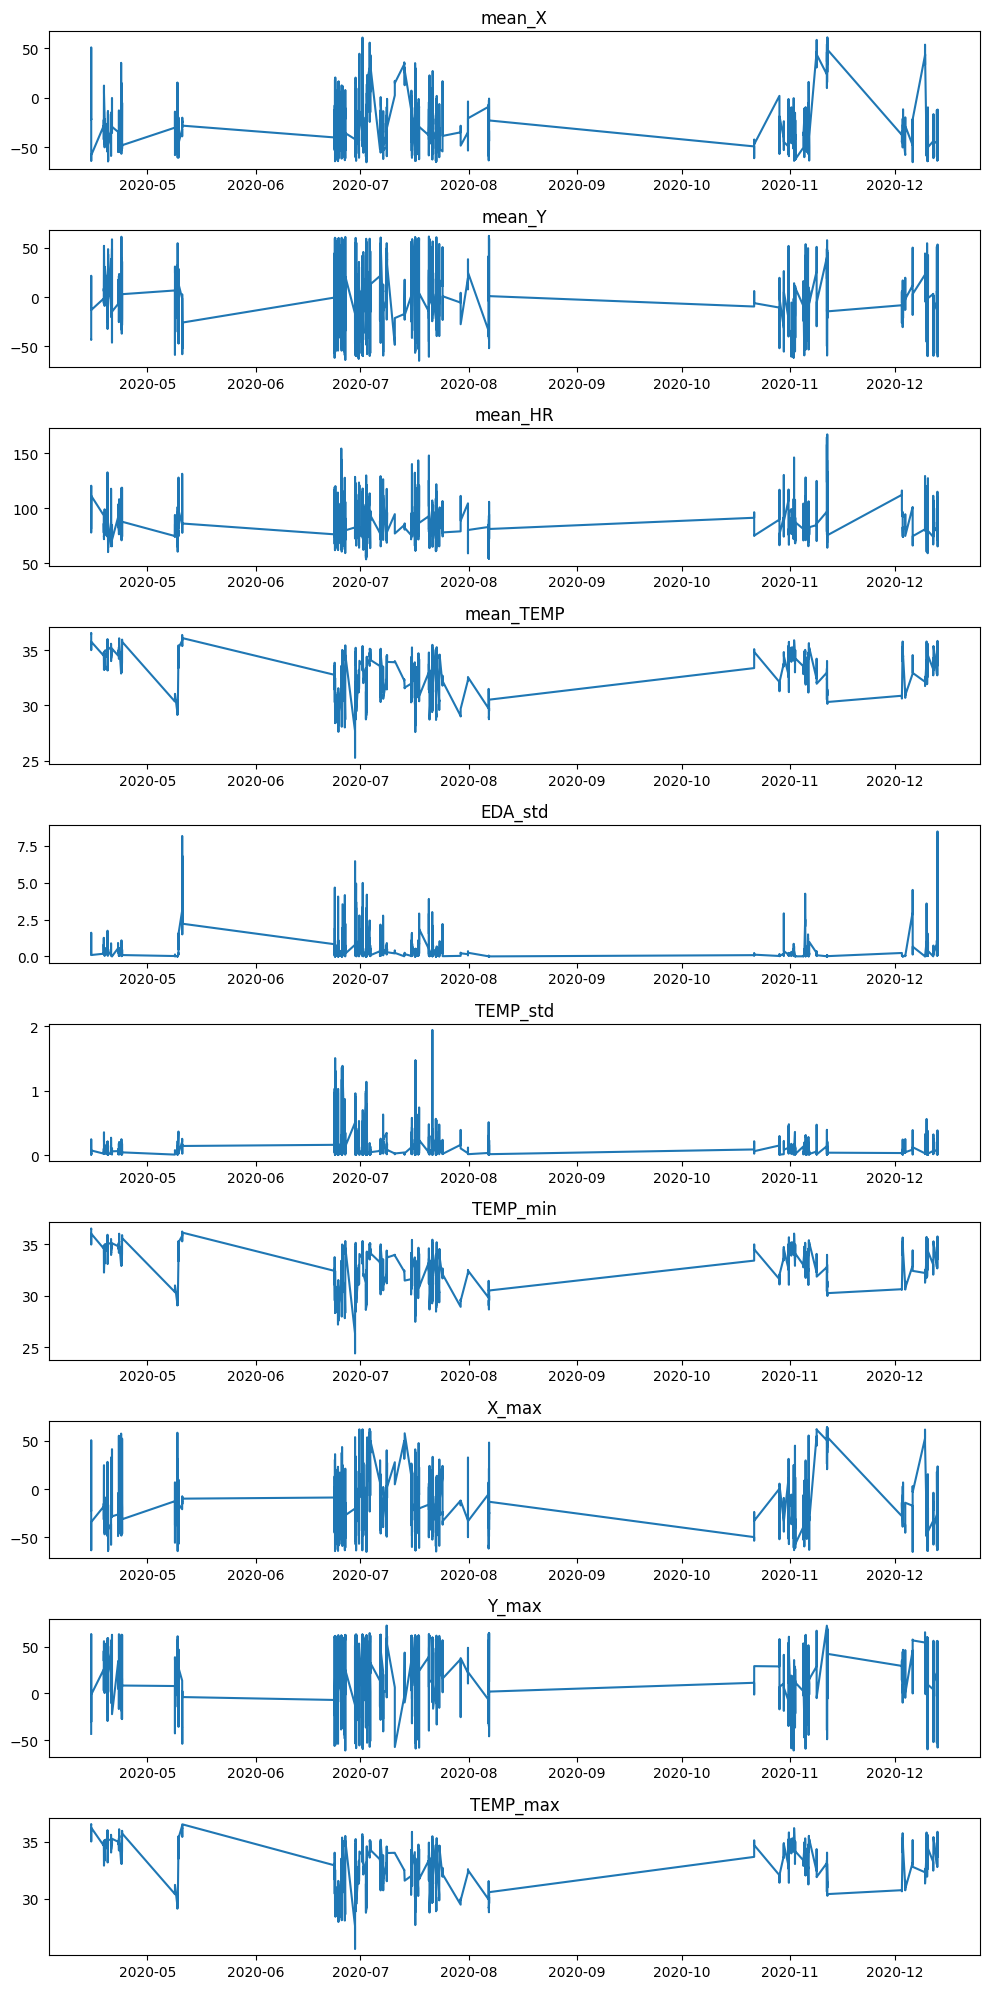

In [48]:
# Plot features extracted over time
fig, axs = plt.subplots(10, 1, figsize=(10, 20))

axs[0].plot(features['mean_X'])
axs[0].set_title('mean_X')

axs[1].plot(features['mean_Y'])
axs[1].set_title('mean_Y')

axs[2].plot(features['mean_HR'])
axs[2].set_title('mean_HR')

axs[3].plot(features['mean_TEMP'])
axs[3].set_title('mean_TEMP')

axs[4].plot(features['EDA_std'])
axs[4].set_title('EDA_std')

axs[5].plot(features['TEMP_std'])
axs[5].set_title('TEMP_std')

axs[6].plot(features['TEMP_min'])
axs[6].set_title('TEMP_min')

axs[7].plot(features['X_max'])
axs[7].set_title('X_max')

axs[8].plot(features['Y_max'])
axs[8].set_title('Y_max')

axs[9].plot(features['TEMP_max'])
axs[9].set_title('TEMP_max')

plt.tight_layout()
plt.show()

In [49]:
# Compute the Pearson correlation coefficient between each feature and the stress label
correlations = features.corr()['label'].abs()

# Select the top 10 features with the highest absolute correlation with the stress label
n = 10
best_features = correlations.sort_values(ascending=False)[1:n+1].index.tolist()

# Print the best features
print(best_features)


['id', 'TEMP_min', 'mean_TEMP', 'HR_max', 'TEMP_max', 'EDA_std', 'mean_HR', 'HR_min', 'EDA_max', 'TEMP_std']


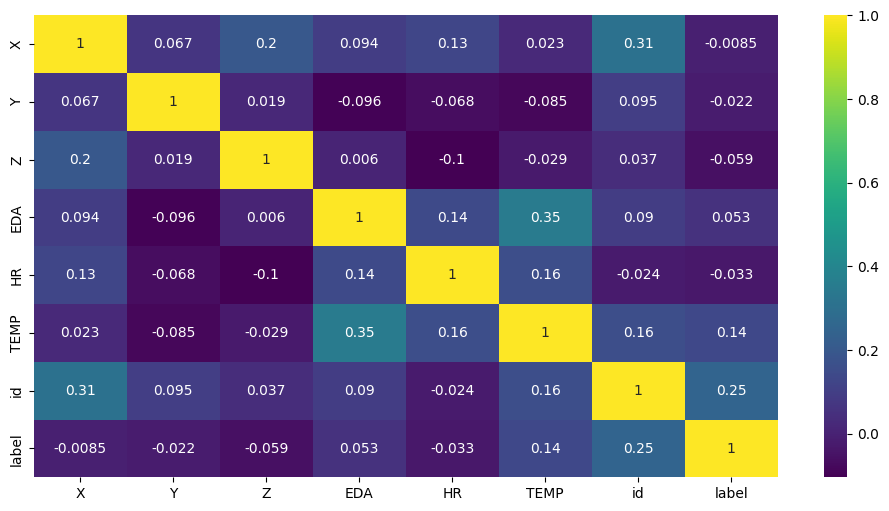

In [50]:
# Visualize the Heatmap with Correlation metrics
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr().transpose(), cmap='viridis',annot = True)
plt.show()

In [51]:
# Select features 'mean_HR', 'mean_TEMP', 'EDA_std', 'TEMP_std', 'TEMP_min', 'TEMP_max' 
final_data = features.loc[:, ['mean_HR', 'mean_TEMP', 'EDA_std', 'TEMP_std', 'TEMP_min', 'TEMP_max', 'label']]
# Normalize the columns
scaler = MinMaxScaler()
final_data[['mean_HR', 'mean_TEMP', 'EDA_std', 'TEMP_std', 'TEMP_min', 'TEMP_max']] = scaler.fit_transform(final_data[['mean_HR', 'mean_TEMP', 'EDA_std', 'TEMP_std', 'TEMP_min', 'TEMP_max']])

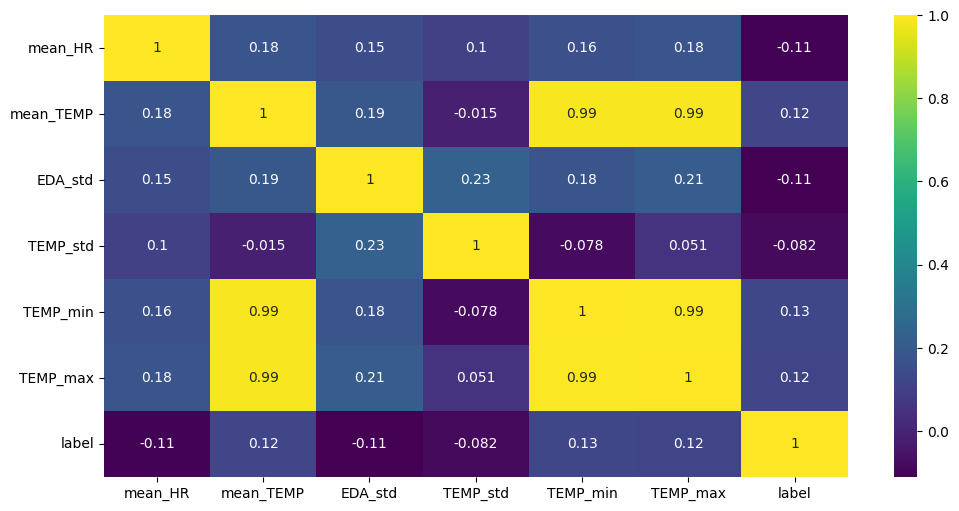

In [52]:
# Visualize the Heatmap with Correlation metrics
plt.figure(figsize=(12, 6))
sns.heatmap(final_data.corr().transpose(), cmap='viridis',annot = True)
plt.show()

In [53]:
# Check number of types of classes in label
num_unique_values = data['label'].nunique()
num_unique_values_final = final_data['label'].nunique()

print(num_unique_values)
print(num_unique_values_final)

3
3


In [54]:
data_RNN = final_data


In [55]:
data_RNN.head()

,mean_HR,mean_TEMP,EDA_std,TEMP_std,TEMP_min,TEMP_max,label
datetime,,,,,,,
2020-04-14 22:32:40,0.250995,0.994537,0.017657,0.006780,0.996296,0.998365,1.0
2020-04-14 22:32:50,0.254842,0.994625,0.024146,0.006542,0.996296,0.998728,1.0
2020-04-14 22:33:00,0.260310,0.994713,0.030914,0.004931,0.996543,0.998728,1.0
2020-04-14 22:33:10,0.266909,0.994864,0.031634,0.004061,0.998107,0.999637,1.0
2020-04-14 22:33:20,0.273841,0.995164,0.032053,0.003825,0.998107,0.999637,1.0


# Model selection

In [56]:
# raw RNN model with LSTM layer
# Train test split
X_RNN = data_RNN.drop(['label'], axis=1).values
y_RNN = data_RNN['label'].values
X_train_RNN, X_test_RNN, y_train_RNN, y_test_RNN = train_test_split(X_RNN, y_RNN, test_size=0.2, random_state=42)

# Reshape the input to 3D
X_train_rnn = np.reshape(X_train_RNN, (X_train_RNN.shape[0], 1, X_train_RNN.shape[1]))
X_test_rnn = np.reshape(X_test_RNN, (X_test_RNN.shape[0], 1, X_test_RNN.shape[1]))

# Add layers
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape=(1, 6)),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
raw_history = model.fit(X_train_rnn, y_train_RNN, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test_RNN))
_, accuracy = model.evaluate(X_test_rnn, y_test_RNN)
print('Test accuracy: %.2f%%' % (accuracy*100))


Epoch 1/10
751/751 [==============================] - 6s 5ms/step - loss: -13.3238 - accuracy: 0.0648 - val_loss: -30.5361 - val_accuracy: 0.0608
Epoch 2/10
751/751 [==============================] - 3s 5ms/step - loss: -43.8710 - accuracy: 0.0647 - val_loss: -57.3030 - val_accuracy: 0.0608
Epoch 3/10
751/751 [==============================] - 4s 5ms/step - loss: -68.2649 - accuracy: 0.0647 - val_loss: -80.7029 - val_accuracy: 0.0608
Epoch 4/10
751/751 [==============================] - 3s 3ms/step - loss: -90.7099 - accuracy: 0.0647 - val_loss: -102.9162 - val_accuracy: 0.0608
Epoch 5/10
751/751 [==============================] - 3s 3ms/step - loss: -112.3835 - accuracy: 0.0647 - val_loss: -124.6709 - val_accuracy: 0.0608
Epoch 6/10
751/751 [==============================] - 4s 5ms/step - loss: -133.6828 - accuracy: 0.0647 - val_loss: -146.1535 - val_accuracy: 0.0608
Epoch 7/10
751/751 [==============================] - 3s 4ms/step - loss: -154.8173 - accuracy: 0.0647 - val_loss: -167

<Axes: >

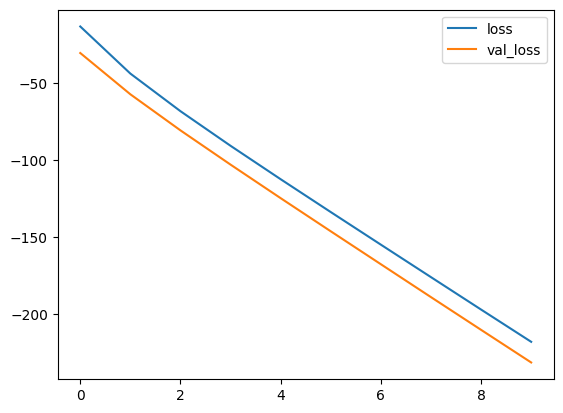

In [57]:
metrices = pd.DataFrame(raw_history.history)
metrices[['loss','val_loss']].plot()

In [58]:
metrices

,loss,accuracy,val_loss,val_accuracy
0,-13.323846,0.064843,-30.536081,0.060803
1,-43.871017,0.064676,-57.302975,0.060803
2,-68.264862,0.064676,-80.702896,0.060803
3,-90.709892,0.064676,-102.916199,0.060803
4,-112.383461,0.064676,-124.670860,0.060803
5,-133.682846,0.064676,-146.153503,0.060803
6,-154.817276,0.064676,-167.510468,0.060803
7,-175.880814,0.064676,-188.841888,0.060803
8,-196.904816,0.064676,-210.058472,0.060803
9,-217.816925,0.064676,-231.217789,0.060803


In [59]:
# Improved RNN with LSTM layers
# Adds two dropout layers with a dropout rate of 0.2 and increases the size of the LSTM layers to 256 and 128 units respectively. 
# L2 regularization with a regularization strength of 0.01 is added to the dense layer. 
# The learning rate for the Adam optimizer is also reduced to 0.01 .
X_RNN = data_RNN.drop(['label'], axis=1).values
y_RNN = data_RNN['label'].values
X_train_RNN, X_test_RNN, y_train_RNN, y_test_RNN = train_test_split(X_RNN, y_RNN, test_size=0.2, random_state=42,stratify=y_RNN)

X_train_rnn = np.reshape(X_train_RNN, (X_train_RNN.shape[0], 1, X_train_RNN.shape[1]))
X_test_rnn = np.reshape(X_test_RNN, (X_test_RNN.shape[0], 1, X_test_RNN.shape[1]))

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=256, input_shape=(1, 6), return_sequences=True),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=128),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(X_train_rnn, y_train_RNN, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test_RNN))

_, accuracy = model.evaluate(X_test_rnn, y_test_RNN)
print('Test accuracy: %.2f%%' % (accuracy*100))

Epoch 1/10
751/751 [==============================] - 20s 19ms/step - loss: -17116.6230 - accuracy: 0.0642 - val_loss: -52573.5000 - val_accuracy: 0.0640
Epoch 2/10
751/751 [==============================] - 14s 18ms/step - loss: -118949.0781 - accuracy: 0.0639 - val_loss: -199254.1406 - val_accuracy: 0.0640
Epoch 3/10
751/751 [==============================] - 14s 19ms/step - loss: -303975.7500 - accuracy: 0.0639 - val_loss: -420421.6250 - val_accuracy: 0.0640
Epoch 4/10
751/751 [==============================] - 14s 18ms/step - loss: -557287.5625 - accuracy: 0.0639 - val_loss: -704491.2500 - val_accuracy: 0.0640
Epoch 5/10
751/751 [==============================] - 13s 18ms/step - loss: -868419.8125 - accuracy: 0.0639 - val_loss: -1042612.3750 - val_accuracy: 0.0640
Epoch 6/10
751/751 [==============================] - 17s 22ms/step - loss: -1231786.3750 - accuracy: 0.0639 - val_loss: -1431317.6250 - val_accuracy: 0.0640
Epoch 7/10
751/751 [==============================] - 13s 18ms/

In [62]:
improved_metrices = pd.DataFrame(history.history)
improved_metrices

,loss,accuracy,val_loss,val_accuracy
0,-1.711662e+04,0.064176,-5.257350e+04,0.063968
1,-1.189491e+05,0.063885,-1.992541e+05,0.063968
2,-3.039758e+05,0.063885,-4.204216e+05,0.063968
3,-5.572876e+05,0.063885,-7.044912e+05,0.063968
4,-8.684198e+05,0.063885,-1.042612e+06,0.063968
5,-1.231786e+06,0.063885,-1.431318e+06,0.063968
6,-1.646430e+06,0.063885,-1.871295e+06,0.063968
7,-2.108858e+06,0.063885,-2.356789e+06,0.063968
8,-2.617403e+06,0.063885,-2.888684e+06,0.063968
9,-3.173474e+06,0.063885,-3.468571e+06,0.063968


In [61]:
# Random forest classifier
# Separate the features and labels
X_RF = final_data.drop(['label'], axis=1)
y_RF = final_data['label']

# Split the data into training and testing sets
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_RF, y_RF, test_size=0.2, random_state=42)

# Define the hyperparameters to tune
param_grid = {"n_estimators": [100, 200, 500],
              "max_depth": [3, 5, 10],
              "min_samples_split": [2, 5, 10]}
              

# Create a Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_RF, y_train_RF)

# Print the best parameters and the corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Test the model on the testing set and calculate recall
y_pred_RF = grid_search.predict(X_test_RF)
recall = recall_score(y_test_RF, y_pred_RF, average='macro')

print("Recall score: ", recall)




Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: ignored

In [ ]:
# SVM model
# Separate features and target label
X_SVM = final_data.drop("label", axis=1)
y_SVM = final_data["label"]  

# Split data into training and testing sets
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X_SVM, y_SVM, test_size=0.2, random_state=42)

# Define pipeline for SVM model
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC())
])

# Define hyperparameters to tune for SVM model
svm_params = {
    "svm__C": [0.1],
    "svm__kernel": [ "poly"],
    "svm__gamma": ["auto"]
}

# Perform grid hyperparameter tuning using cross-validation for SVM model
svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5)   
svm_grid.fit(X_train_SVM, y_train_SVM)

# Print best parameters and cross-validation scores for SVM model
print("SVM: Best Params:", svm_grid.best_params_)
print("Best score: ", grid_search.best_score_)

# Predict the target labels on the test set using the best estimator
y_pred_SVM = svm_grid.best_estimator_.predict(X_test_SVM)

# Print the recall score
print("Recall score: ", recall_score(y_test_SVM, y_pred_SVM, average='macro'))



In [ ]:
# KNN model
# Separate features and target label
X_KNN = final_data.drop("label", axis=1)
y_KNN = final_data["label"]  

# Split the data into training and testing sets
X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X_KNN, y_KNN, test_size=0.2, random_state=42)

# Define pipeline for KNN model
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# Define hyperparameters to tune for KNN model
knn_params = {
    "knn__n_neighbors": [3, 5, 10],
    "knn__weights": ["uniform", "distance"],
    "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
}

# Perform grid hyperparameter tuning using cross-validation for KNN model
knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=5)
knn_grid.fit(X_train_KNN, y_train_KNN)

# Print best parameters and cross-validation scores for KNN model
print("KNN: Best Params:", knn_grid.best_params_)
print("KNN: Cross-Validation Scores:", cross_val_score(knn_grid.best_estimator_, X_train_KNN, y_train_KNN, cv=5))

# Test the model on the testing set
y_pred_KNN = knn_grid.predict(X_test_KNN)
print("Test Recall:", recall_score(y_test_KNN, y_pred_KNN,average='macro'))




In [ ]:
# Improved KNN model 
# Separate features and target label
X_KNN = final_data.drop("label", axis=1)
y_KNN = final_data["label"]  

# Split the data into training and testing sets
X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X_KNN, y_KNN, test_size=0.2, random_state=42)

# Define pipeline for KNN model
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# Define hyperparameters to tune for KNN model
knn_params = {
    "knn__n_neighbors": [3, 5, 10],
    "knn__weights": ["uniform", "distance"],
    "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "knn__metric": ["euclidean", "manhattan", "minkowski"]
}

# Perform grid hyperparameter tuning using cross-validation for KNN model
knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=5)
knn_grid.fit(X_train_KNN, y_train_KNN)

# Print best parameters and cross-validation scores for KNN model
print("KNN: Best Params:", knn_grid.best_params_)
print("KNN: Cross-Validation Scores:", cross_val_score(knn_grid.best_estimator_, X_train_KNN, y_train_KNN, cv=5))

# Test the model on the testing set
y_pred_KNN = knn_grid.predict(X_test_KNN)
print("Test Recall (Euclidean):", recall_score(y_test_KNN, y_pred_KNN, average='macro'))

# Test the model on the testing set using Manhattan distance metric
knn_grid.best_estimator_.set_params(knn__metric="manhattan")
y_pred_KNN = knn_grid.predict(X_test_KNN)
print("Test Recall (Manhattan):", recall_score(y_test_KNN, y_pred_KNN, average='macro'))

# Test the model on the testing set using Minkowski distance metric
knn_grid.best_estimator_.set_params(knn__metric="minkowski")
y_pred_KNN = knn_grid.predict(X_test_KNN)
print("Test Recall (Minkowski):", recall_score(y_test_KNN, y_pred_KNN, average='macro'))


In [ ]:
# Define the metrics for each model
svm_recall = 0.3404077624006718
knn_recall = 0.777188801440262
knn_manhattan_recall = 0.8523846418145342
rf_recall = 0.5066273932258821

# Define the x-axis labels
models = ['SVM', 'KNN', 'KNN (Manhattan)', 'Random Forest']

# Define the y-axis values
recall_scores = [svm_recall, knn_recall, knn_manhattan_recall, rf_recall]

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(models, recall_scores)

# Add labels and titles
ax.set_xlabel('Model')
ax.set_ylabel('Recall Score')
ax.set_title('Recall Scores for Different Models')

# Add text labels to each bar
for i, v in enumerate(recall_scores):
    ax.text(i-0.1, v+0.01, str(round(v, 2)), color='black', fontweight='bold')

# Show the plot
plt.show()

In [ ]:
# Define the model names and their accuracy scores
models = ["SVM", "KNN (Euclidean)", "KNN (Manhattan)", "Random Forest"]
accuracies = [0.818, 0.777, 0.852,  0.818]

# Plot the bar chart
plt.bar(models, accuracies, color=['blue'])
plt.ylim(0.5, 1)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Different Models")
plt.show()